<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S7: Clasificación de sentimientos en tweets

## Objetivos:

El objetivo de este challenge es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.feature_extraction.text import CountVectorizer


In [2]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
sentiment    8414 non-null object
text         8414 non-null object
dtypes: object(2)
memory usage: 131.5+ KB


In [3]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
sentiment    2153 non-null object
text         2153 non-null object
dtypes: object(2)
memory usage: 33.7+ KB


Damos un vistazo a los textos que aparecen en el dataset.

In [4]:
df_train.head()

sentiment  \
0   Neutral   
1  Positive   
2   Neutral   
3  Positive   
4  Positive   

                                                                                                                                           text  
0                                    RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate  
1  RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…  
2                                                          RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.  
3  RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …  
4  RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…

In [5]:
df_test.head()

sentiment  \
0  Positive   
1   Neutral   
2  Positive   
3  Negative   
4  Positive   

                                                                                                                                        text  
0    RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews  
1                                                                      Going on #MSNBC Live with @ThomasARoberts around 2 PM ET.  #GOPDebate  
2  RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV  
3  reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate  
4                                                                 RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate

## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

- Dataset de entrenamiento:
    Tenemos 4872 tweets negativos, 2162 tweets neutrales y 1380 positivos.
    
- Dataset de test:
    Tenemos 1257 tweets negativos, 567 tweets neutrales y 329 positivos.

In [6]:
df_train['sentiment'].value_counts()

Negative    4872
Neutral     2162
Positive    1380
Name: sentiment, dtype: int64

In [7]:
df_test['sentiment'].value_counts()

Negative    1257
Neutral      567
Positive     329
Name: sentiment, dtype: int64

## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

Al tener un dataset un poco desbalanceado nos resultará más complicado poder realizar una buena clasificación.

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [8]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [9]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf.fit(df_train['text'], df_train['sentiment'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [10]:
predicted = text_clf.predict(df_test['text'])
np.mean(predicted == df_test['sentiment'])

0.5973060845332094

Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [11]:
def clean_text(text):
    
    cleaned_text = []
    separadores = [',', '.', ';', ':', '?', '¿', '!', '¡', '*', '``', ')', '(', '*', 'rt', '', '"', "https"]
    for palabra in text:
        if palabra in separadores:
            pass
        elif palabra.startswith('@'):
            pass
        else:
            cleaned_text.append(palabra)
    
    return cleaned_text

def stemmizar(text):
    word_stem = []
    for word in text:
        word_stem.append(stemmer.stem(word))
    return word_stem

def preprocesar_texto(texto):
    """ Función para preprocesamiento de texto.
    Args:
        texto: cadena de texto a preprocesar.
    Returns:
        mismo texto preprocesado.
    """   
    texto = texto.lower()
    words = TweetTokenizer().tokenize(texto)
    
    cleaned_text = clean_text(words)
    texto_filtrado = stemmizar(cleaned_text)
    
    texto_filtrado = " ".join(texto_filtrado)
    
    return texto_filtrado

Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [12]:
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)

df_train

sentiment  \
0      Neutral   
1     Positive   
2      Neutral   
3     Positive   
4     Positive   
5     Negative   
6     Negative   
7     Negative   
8     Negative   
9     Negative   
10     Neutral   
11    Positive   
12    Negative   
13    Negative   
14    Negative   
15    Negative   
16    Negative   
17    Negative   
18     Neutral   
19    Negative   
20    Negative   
21    Negative   
22    Negative   
23    Negative   
24    Negative   
25     Neutral   
26     Neutral   
27    Negative   
28    Negative   
29     Neutral   
...        ...   
8384   Neutral   
8385  Negative   
8386  Negative   
8387  Negative   
8388  Negative   
8389  Negative   
8390  Negative   
8391  Positive   
8392  Positive   
8393  Negative   
8394  Negative   
8395  Negative   
8396   Neutral   
8397  Negative   
8398  Positive   
8399   Neutral   
8400  Negative   
8401  Negative   
8402  Negative   
8403   Neutral   
8404  Negative   
8405  Positive   
8406  Negative   
8407   Neutral   
8408  Negative   
8409  Negative   
8410  Negative   
8411   Neutral   
8412  Negative   
8413  Positive   

                                                                                                                                                 text  \
0                                          RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate   
1        RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…   
2                                                                RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.   
3        RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …   
4        RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…   
5        RT @warriorwoman91: I liked her and was happy when I heard she was going to be the moderator. Not anymore. #GOPDebate @megynkelly  https://…   
6              Deer in the headlights RT @lizzwinstead: Ben Carson, may be the only brain surgeon who has performed a lobotomy on himself. #GOPDebate   
7                            RT @NancyOsborne180: Last night's debate proved it! #GOPDebate #BATsAsk @BadassTeachersA #TBATs  https://t.co/G2gGjY1bJD   
8                                                                 @JGreenDC @realDonaldTrump In all fairness #BillClinton owns that phrase.#GOPDebate   
9                                                           Me reading my family's comments about how great the #GOPDebate was http://t.co/gIaGjPygXZ   
10                                               RT @ArcticFox2016: RT @AllenWestRepub "Dear @JebBush #GOPDebate #NotAMistake http://t.co/TtFG7KYcd9"   
11                                    RT @pattonoswalt: I loved Scott Walker as Mark Harmon's romantic rival in SUMMER SCHOOL. Look it up. #GOPDebate   
12                               Hey @ChrisChristie exploiting the tragedy of 9/11 for your own political gain is @rudygiulianiGOP's thing #GOPDebate   
13       RT @CarolCNN: #DonaldTrump under fire for comments about women @PeterBeinart @SL_Schaeffer @IWF @@MyRkiger weigh in on #GOPdebate http://t.…   
14               RT @johncardillo: Guess who had most speaking time at the #GOPDebate. @FoxNews moderators with 31.7% of time. http://t.co/2WSUT0c0Lx   
15         RT @PamelaGeller: Huckabee: Paying for transgender surgery for soldiers, sailors and airmen does not make our country safer #Ha #GOPDebate   
16            RT @mchamric: RT “@TeaTraitors: #GOPDebate was still Clown Show! I'm glad Head Clown Trump helping destroy GOP. http://t.co/nwGx8G8JWr”   
17                    RT @erinmallorylong: No *I* hate Planned Parenthood and women more! NO I HATE PLANNED PARENTHOOD AND WOMEN MORE!

In [13]:
df_test

sentiment  \
0     Positive   
1      Neutral   
2     Positive   
3     Negative   
4     Positive   
5     Negative   
6     Negative   
7     Negative   
8     Negative   
9     Negative   
10    Negative   
11     Neutral   
12    Negative   
13    Negative   
14    Negative   
15    Negative   
16    Negative   
17    Positive   
18    Negative   
19    Negative   
20     Neutral   
21     Neutral   
22     Neutral   
23    Negative   
24    Negative   
25    Negative   
26    Negative   
27    Negative   
28    Negative   
29    Negative   
...        ...   
2123  Negative   
2124  Negative   
2125  Negative   
2126   Neutral   
2127  Negative   
2128   Neutral   
2129  Negative   
2130   Neutral   
2131  Negative   
2132  Negative   
2133  Negative   
2134   Neutral   
2135  Negative   
2136  Positive   
2137  Negative   
2138  Positive   
2139  Negative   
2140  Negative   
2141  Negative   
2142   Neutral   
2143  Negative   
2144  Positive   
2145  Negative   
2146  Negative   
2147  Negative   
2148  Negative   
2149  Negative   
2150   Neutral   
2151  Positive   
2152  Positive   

                                                                                                                                                       text  \
0                   RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews   
1                                                                                     Going on #MSNBC Live with @ThomasARoberts around 2 PM ET.  #GOPDebate   
2                 RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV   
3                 reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate   
4                                                                                RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate   
5              RT @MrPooni: Fox News trying to convince us young Black Americans are more worried about ISIS than police terrorism #GOPDebate http://t.co/…   
6              RT @feministabulous: It's not a competition, but how have we moved so far on gay rights but women's rights is worse than it's ever been? #G…   
7                                  RT WinesdayPodcast : An update on FoxNews tech failures for the #GOPDebate http://t.co/FGGlf2J5HU http://t.co/Zw35DkUozi   
8           RT @AmyMek: The Torched has been passed -&gt;.@CandyCrowley is no longer the most Famous Political Assassin! Congratulations @megynkelly, U Wi…   
9              RT @kvxrdashian: Jeb Bush: "Obama is at fault, not my brother, because Obama didn't clean up the mess my brother made." #GOPDebate http://t…   
10                                                                  RT @JamelleMyBelle: Meanwhile, in the White House...  #GOPDebate http://t.co/nouUUt5hKq   
11                                               RT @RowdyGentleman: If you’re planning out a #GOPDebate drinking game right now, you’re a Rowdy Gentleman.   
12                                                                                   RT @brownblaze: PLEASE RT. #KKKorGOP #GOPDebate http://t.co/YaqYAC3uV3   
13              Trump thinks criticism of his misogynistic remarks is a "political correctness" problem. Nope, it's a pervasive #sexism problem. #GOPDebate   
14         RT @STYLEMOM: Here's a question, WHY in the hell are WOMEN &amp; our body parts even in this debate? Foh, stop it, it's not 1965 wtf #GOPDebate…   
15                       RT @ChuckNellis: I won't defend @FoxNews, they were FAR from fair OR balanced last night, but name calling is juvenile. #GOPDebate   
16             RT @theskysgoneout: To non-Christians, #GOPDebate "God" questions underline how little anyone really cares about religious minorities. Chri…   
17        RT @_Holly_Renee

Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto. Podemos observar frecuencia de palabras o simplemente generar un WordCloud.

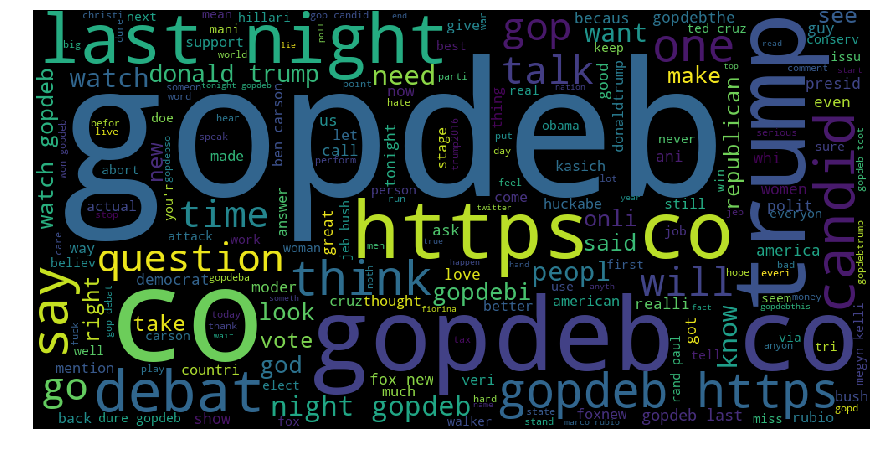

In [14]:
from wordcloud import WordCloud
filter_text = df_train['prep']

frase = ""
for row in filter_text:
    frase = frase + row

    
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(frase)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [15]:
# Nuevo pipeline si es que es necesario. Por defecto usamos el anterior.
text_clf_2 = Pipeline([('vect', CountVectorizer(tokenizer = TweetTokenizer().tokenize)),
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf=True)),
                     ('clf', LinearSVC())])

text_clf_2.fit(df_train['prep'], df_train['sentiment'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [16]:
# Predicción haciendo uso de TF-IDF. ¡Recuerda cambiarlo si has creado uno nuevo!
predicted = text_clf_2.predict(df_test['prep'])
np.mean(predicted == df_test['sentiment'])

0.6339990710636322

In [17]:
#Predicción haciendo uso del pipeline que se usó al principio - BoW
new_clf = text_clf
new_clf.fit(df_train['prep'], df_train['sentiment'])
predicted_new = new_clf.predict(df_test['prep'])
np.mean(predicted_new == df_test['sentiment'])

0.5973060845332094

* ¿Qué opinas de los resultados obtenidos?
* ¿Por qué crees que ha sucedido esto?

Se observa que se ha mejorado mínimamente la predicción usando cualquiera de ambas técnicas (Bag of Words y TF-IDF). Se observan unos resultados mejores con TF-IDF.  Además he observado que usando POS y quedándome únicamente con los adjetivos la precisión también disminuye - puede que debido a que se obtenían muchos tweets vacíos y esto hará que tenga menos valores para la predicción.

##### ¿Podrías explicarme con tus palabras en qué consiste Tf-Idf? ¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

Es una técnica que nos permite averiguar la relevancia de una palabra dentro de un documento. Se basa en medir la frecuencia con la que aparece una palabra dentro de un documento y compararla con el resto de docuemntos. Si esta palabra es muy frecuente en ese documento únicamente le dará más relevancia mientras que si se repite en ese y en otros docuemntos muchas veces, le dará menos relevancia ya que la tratará como palabra frecuente.

El aplicar esta transformación a la matriz sería bueno ya que así podríamos quitarle relevancia a palabras que son más frecuentes y que no aportan ningún valor a esta clasificación, como por ejempo https, gopdeb, debate y otras palabras usuales del lenguaje como only, one ...